In [1]:
import numpy as np
from os.path import isfile
from os import environ

from skimage.io import imread
from skimage import measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def find_files_like(datapath, startswith, endswith='.npz'):
    from os import listdir
    
    # look for file in folder `datapath` that starts with `startswith`
    filename = []
    for file in listdir(datapath):
        if file.startswith(startswith) and file.endswith(endswith):
            filename.append(file)
    
    return filename

In [3]:
def calc_shape(img):
    # get components of the centroid
    M = measure.moments(img, 1)
    xm = M[0, 1] / M[0, 0]
    ym = M[1, 0] / M[0, 0]
    
    # size
    size = M[0, 0]
    
    # get centralized moments
    mu = measure.moments_central(img, xm, ym)
    muprime = mu / size
    
    # covariance matrix
    cov = np.array([[muprime[2, 0], muprime[1, 1]], [muprime[1, 1], muprime[0, 2]]])
    
    # eigenvalues and eigenvectors
    w, v = np.linalg.eig(cov)
    
    # orientation
    if muprime[2, 0] != muprime[0, 2]:
        theta = 0.5 * np.arctan2(2 * muprime[1, 1], muprime[2, 0] - muprime[0, 2])
    else:
        print("Can't compute `theta` because mu'_20 == mu'_02 == %f" % muprime[2, 0])
        theta = None
        
    # eccentricity
    ecc = np.sqrt(1.0 - np.min(w) / np.max(w))
    
    return size, theta, ecc, w

In [4]:
img_rand = np.round(np.random.rand(100*100).reshape((100, 100)))
assert calc_shape(img_rand)[0] == np.sum(img_rand)

In [5]:
def find_bitmaps(folder, electrodes=[], amps=[]):
    # Given a list of electrodes and amplitude values, finds the corresponding
    # bitmap files in `folder`
    import pandas as pd
    
    if not folder.endswith('/'):
        folder += '/'
    
    # Open file
    files = find_files_like(folder, 'VIDFileListNew_', '.xls')
    if not files:
        raise ValueError('Could not find file')
    else:
        file = files[0]

    # Parse file
    xl = pd.ExcelFile(folder + file)
    df = xl.parse(xl.sheet_names[0])  # assume Sheet 1
    assert 'electrode' in df.columns
    assert 'amplitude' in df.columns
    
    if electrodes and amps:
        # Find rows with right electrodes and amplitude values
        col_el = '_'.join(electrodes)
        col_amp = '_'.join(amps) + '_'
        rows = df.loc[(df['electrode'] == col_el) & (df['amplitude'] == col_amp)]
    else:
        rows = df
    
    return [folder + bmp_folder + '/' + bmp_file
            for bmp_folder, bmp_file in zip(rows['foldername'], rows['filename'])]

In [6]:
def pixel2deg(px_area, px_shape=[384, 384], deg_shape=[80, 80]):
    num_pixels = np.prod(px_shape)
    num_deg = np.prod(deg_shape)
    return px_area / num_pixels * num_deg

In [7]:
def deg2pixel(deg_area, px_shape=[384, 384], deg_shape=[80, 80]):
    num_pixels = np.prod(px_shape)
    num_deg = np.prod(deg_shape)
    return deg_area / num_deg * num_pixels

In [8]:
assert pixel2deg(384*384) == 80*80
assert deg2pixel(80*80) == 384*384

In [9]:
def parse_bitmap_shape(files):
    img = []
    size = []
    theta = []
    ecc = []
    eigen = []
    for f in files:
        if not isfile(f):
            print('Could not find file "' + f + '"')
            continue

        img.append(rgb2gray(imread(f)))
        s, t, e, w = calc_shape(img[-1])
        size.append(s)
        theta.append(t)
        ecc.append(e)
        eigen.append(w)

    size = np.array(size)
    theta = np.array(theta)
    ecc = np.array(ecc)
    eigen = np.array(eigen)
    
    return img, size, theta, ecc, eigen

In [10]:
subject = 'TB'
exp_date = '20080702'

exp_name = 'lambda2.0'
sim_date = '2017-01-22'
name_E1 = 'L1'
name_E2 = None

In [11]:
simpath = '%s/data/shape/%s/%s/%s' % (environ['HOME'], subject, exp_date, sim_date)
secondsightpath = '%s/shape/%s/%s' % (environ['SECOND_SIGHT_DATA'], subject, exp_date)

In [12]:
# Find the simulation files
prefix = '%s_%s_%s' % (exp_name, name_E1, name_E2)
filenames = find_files_like(simpath, prefix, '.npz')
if not filenames:
    print('Could not locate any files with "' + prefix + '"*')
else:
    file = filenames[0]
    print('Found file "' + file + '"')

Found file "lambda2.0_L1_None.npz"


In [13]:
assert file
exp_data = np.load(simpath + "/" + file)
data = exp_data['data'][()]
exp_params = exp_data['exp_params'][()]
model = exp_data['model'][()]

In [14]:
E1 = model['implant'][name_E1]
amp_frac = np.array(data['cond1']['amp_E1']) / E1.threshold

(0, 84.254166666666649)
- 14.44	27.44
(1, 101.10499999999999)
- 18.76	39.77
(2, 134.80666666666664)
- 26.53	38.91
(3, 202.20999999999998)
- 45.91	63.86
(4, 269.61333333333329)
- 65.03	87.94
Size MSE = 1611.15


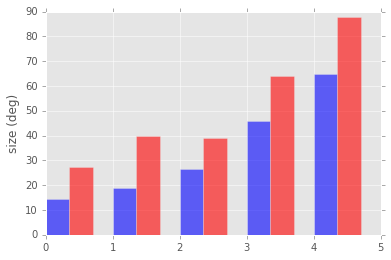

In [15]:
size_mse = 0
for idx, amp in enumerate(data['cond1']['amp_E1']):
    print((idx, amp))
    
    # Look up the bitmaps
    bitmaps = find_bitmaps(secondsightpath, [name_E1], [str(amp / E1.threshold)])
    if not bitmaps:
        # Stupid strings, try rounding...
        bitmaps = find_bitmaps(secondsightpath, [name_E1], [str(int(amp / E1.threshold))])
    if not bitmaps:
        print('Could not find the bitmaps for ' + str(amp) + ', skip...')
        continue
        
    # Calculate moments for bitmaps
    img_real, size_real, theta_real, ecc_real, eigen_real = parse_bitmap_shape(bitmaps)
    size_real = pixel2deg(size_real)
    
    # Calculate the same for model
    frame = data['cond1']['frames'][idx].data
    img_pred = np.double(frame >= threshold_otsu(frame))
    size_pred, theta_pred, ecc_pred, eigen_pred = calc_shape(img_pred)
    size_pred = pixel2deg(size_pred, px_shape=frame.shape,
                          deg_shape=[e2cm.micron2deg(model['retina'].gridy.max() - model['retina'].gridy.min()),
                                     e2cm.micron2deg(model['retina'].gridx.max() - model['retina'].gridx.min())])
    print('- %.2f\t%.2f' % (size_pred, np.mean(size_real)))
    
    size_mse += (size_pred - np.mean(size_real)) ** 2
    
    bar_width = 0.35
    plt.bar(idx, size_pred, bar_width, color='b', alpha=0.6)
    plt.bar(idx + bar_width, np.mean(size_real), bar_width, color='r', alpha=0.6)
    plt.ylabel('size (deg)')
print('Size MSE = %.2f' % size_mse)

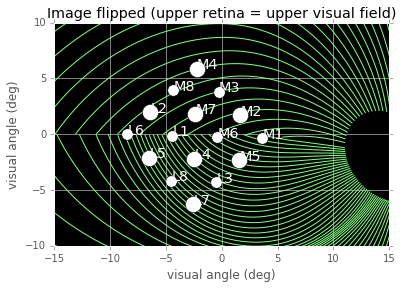

In [16]:
# Plot axon bundles (plot every 5th for the sake of visualization)
fig, ax = plt.subplots(1)
ax.set_axis_bgcolor('black')
ax.plot(model['retina'].jan_x[:, ::5], -model['retina'].jan_y[:, ::5],
        c=(0.5, 1, 0.5))

# Plot location of implant on top of axon bundles
for e in model['implant']:
    ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5),
            e.name, color='white', size='x-large')
    ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
            markersize=np.sqrt(e.radius))
ax.set_aspect('equal')
ax.set_xlim(-15, 15)
ax.set_xlabel('visual angle (deg)')
ax.set_ylim(-10, 10)
ax.set_ylabel('visual angle (deg)')
ax.set_title('Image flipped (upper retina = upper visual field)')

In [17]:
plt.style.use('fivethirtyeight')

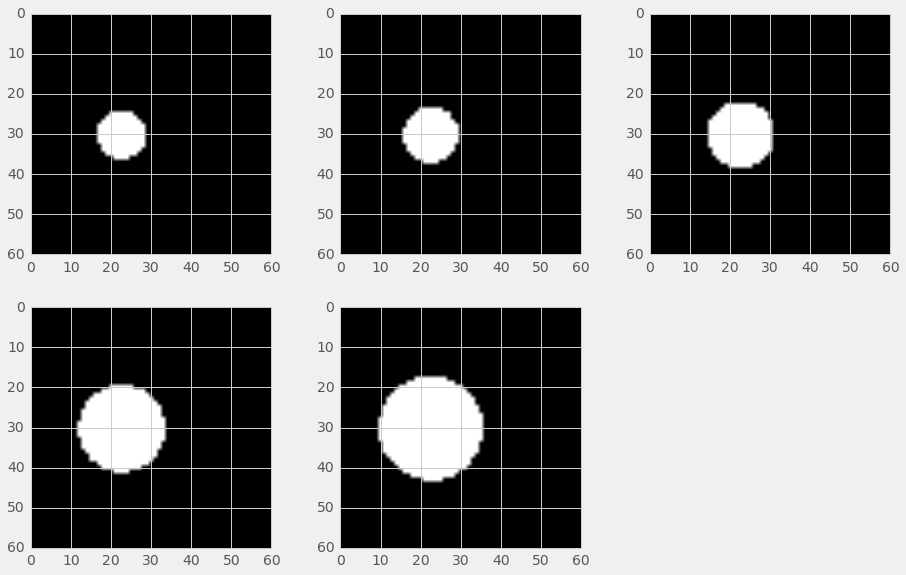

In [18]:
plt.figure(figsize=(14, 9))
for i, f in enumerate(data['cond1']['frames']):
    plt.subplot(2, 3, i + 1)
    plt.imshow(f.data >= threshold_otsu(f.data), cmap='gray')